In [1]:
# Add the current directory to the load path to find the module
using LinearAlgebra
using SparseArrays
using Statistics
using Plots 
using Revise
using StatsBase
using Parameters

In [2]:
# Include the main module which handles internal dependencies
# Ensure HubbardModel.jl is in the 'src' directory relative to the notebook
includet("src/HubbardModel.jl")
using .HubbardModel

## Band Structure Calculation (Square Lattice)

Using functions and constants defined in the modules.

In [ ]:
# Define high-symmetry points using constants from HubbardModel.ReciprocalSpace
Γ = HubbardModel.ReciprocalSpace.Γ
X = HubbardModel.ReciprocalSpace.X
M = HubbardModel.ReciprocalSpace.M
path_points = HubbardModel.ReciprocalSpace.KPATH

# Generate k-path using the module function
k_vec, k_positions = HubbardModel.ReciprocalSpace.generate_k_path(path_points, 500)

# Calculate bands using the module function
εk_minus = Float64[]
εk_plus = Float64[]
for k_point in k_vec
    em, ep = HubbardModel.ReciprocalSpace.get_bands(k_point, HubbardModel.ReciprocalSpace.b1, HubbardModel.ReciprocalSpace.b2)
    push!(εk_minus, em)
    push!(εk_plus, ep)
end

# Calculate single-cell dispersion for comparison
dummy_params = HubbardModel.HInit.HubbardParams(4, 2, 2, HubbardModel.ReciprocalSpace.t, 0.0)
ε_single = HubbardModel.ReciprocalSpace.calculate_dispersion(dummy_params, k_vec)

# Plotting
plot(εk_minus, label="ε₋ (Double Cell)", linewidth=2)
plot!(εk_plus, label="ε₊ (Double Cell)", linewidth=2)
plot!(ε_single, label="ε (Single Cell, U=0)", linewidth=2, linestyle=:dash, color=:black)

total_k_dist = k_positions[end]
tick_positions = [pos / total_k_dist * length(k_vec) for pos in k_positions]
tick_labels = ["Γ", "X", "M", "Γ"]
xticks!(tick_positions, tick_labels)
vline!(tick_positions[2:end-1], color=:black, linestyle=:dash, label="")

xlabel!("k-path")
ylabel!("Energy (t)")
title!("Band Structure")

## Density of States (DOS)

In [ ]:
# Calculate energies over the full Brillouin Zone
nk_dos = 100
energies_double = Float64[]
energies_single_dos = Float64[]

# Access constants via HubbardModel.ReciprocalSpace
kx_max = HubbardModel.ReciprocalSpace.X[1]
ky_max = HubbardModel.ReciprocalSpace.M[2]

for kx in LinRange(-kx_max, kx_max, nk_dos), ky in LinRange(-ky_max, ky_max, nk_dos)
    k_point = [kx, ky]
    em, ep = HubbardModel.ReciprocalSpace.get_bands(k_point, HubbardModel.ReciprocalSpace.b1, HubbardModel.ReciprocalSpace.b2)
    push!(energies_double, em)
    push!(energies_double, ep)
    ε_s = -2 * HubbardModel.ReciprocalSpace.t * (cos(kx) + cos(ky))
    push!(energies_single_dos, ε_s)
end

# Plot DOS
histogram(energies_double, bins=100, normalize=:pdf, label="Double Cell DOS", alpha=0.6)
histogram!(energies_single_dos, bins=100, normalize=:pdf, label="Single Cell DOS", alpha=0.6)
xlabel!("Energy (t)")
ylabel!("Density of States")
title!("Density of States")

In [ ]:
# Alternative DOS plot using StatsBase
hist_double = fit(Histogram, energies_double, nbins=100)
hist_single = fit(Histogram, energies_single_dos, nbins=100)

edges = hist_double.edges[1]
bin_centers = 0.5 .* (edges[1:end-1] .+ edges[2:end])

bin_width = edges[2] - edges[1]
dos_double = hist_double.weights ./ (sum(hist_double.weights) * bin_width)
dos_single = hist_single.weights ./ (sum(hist_single.weights) * bin_width)

plot(bin_centers, dos_double, label="Double cell DOS", lw=2)
plot!(bin_centers, dos_single, label="Single cell DOS", lw=2, linestyle=:dash)
xlabel!("Energy (t)")
ylabel!("Density of States")
title!("Density of States (StatsBase)")

# U neq 0

In [ ]:
using Statistics # Add this line to use mean()

p = HubbardModel.MFParams(U=4.0, t=1.0, ne=1.0, Nk=100, β=50.0, tol=1e-6, maxiter=200)
# Qualify the function call with the module name
# Assign return values to intermediate variables
nup_vec, ndown_vec, E_tot = HubbardModel.self_consistent_mf(p)

# Calculate average densities per site (if desired)
nup = mean(nup_vec)
ndown = mean(ndown_vec)

# Print average densities and total energy
println("Average ⟨n↑⟩ = ", nup, " Average ⟨n↓⟩ = ", ndown, " E = ", E_tot)
# Optionally print sublattice densities
println("Sublattice n↑ = ", nup_vec, " Sublattice n↓ = ", ndown_vec)


In [3]:
# Define parameter ranges
ne_values = 0.4:0.2:2.0
U_values = 1.0:1.0:8.0
t_val = 1.0 # Hopping parameter

# Create a list of MFParams for the grid
params_list = HubbardModel.MFParams[]
for ne in ne_values
    for U in U_values
        # Use parameters similar to cell 9, adjust Nk for speed if needed
        p = HubbardModel.MFParams(U=U, t=t_val, ne=ne, Nk=20, β=50.0, tol=1e-5, maxiter=150)
        push!(params_list, p)
    end
end

println("Total parameter points: ", length(params_list))

# Compute the phase diagram
# This might take a while depending on Nk, grid size, and maxiter
phase_indices = HubbardModel.compute_phase_diagram(params_list)

# Reshape the result into a grid matching ne_values and U_values
phase_grid = reshape(phase_indices, (length(U_values), length(ne_values)))' # Transpose to have ne on rows, U on columns

println("Phase diagram computation complete.")
# You can now plot this phase_grid, e.g., using Plots.heatmap
# Example: heatmap(U_values, ne_values, phase_grid, xlabel="U/t", ylabel="ne", title="Mean-Field Phase Diagram", colorbar_title="Phase (1:PM, 2:FM, 3:AFM)")

Total parameter points: 72
Calculating point 1/72: ne=0.4, U=1.0
SCF converged in 3 iterations. μ = -1.8611390590667725
SCF converged in 3 iterations. μ = -1.8611407540738583
SCF converged in 3 iterations. μ = -1.8611391559243202
  -> Phase: PM, E_PM=-0.06918633730882381, E_FM=-0.06918625555959204, E_AFM=-0.06918633263758293
Calculating point 2/72: ne=0.4, U=2.0
SCF converged in 3 iterations. μ = -1.860016405582428
SCF converged in 3 iterations. μ = -1.860016405582428
SCF converged in 3 iterations. μ = -1.860016405582428
  -> Phase: PM, E_PM=-0.04303979208314804, E_FM=-0.04303979208314804, E_AFM=-0.04303979208314804
Calculating point 3/72: ne=0.4, U=3.0
SCF converged in 2 iterations. μ = -1.859747938811779
SCF converged in 2 iterations. μ = -1.859747938811779
SCF converged in 2 iterations. μ = -1.859747938811779
  -> Phase: PM, E_PM=-0.03204806516293142, E_FM=-0.03204806516293142, E_AFM=-0.03204806516293142
Calculating point 4/72: ne=0.4, U=4.0
SCF converged in 3 iterations. μ = -1.857

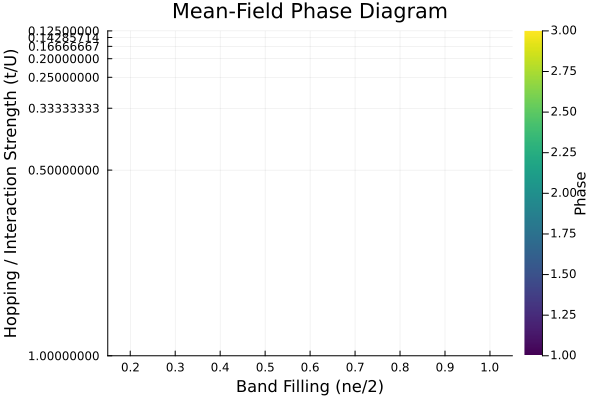

y points not sorted in ascending order
y points not sorted in ascending order
y points not sorted in ascending order


In [4]:
# Transform the axes values
x_axis_values = ne_values / 2
y_axis_values = t_val ./ U_values

# Transpose the phase grid to match the new axes orientation
# Original grid: rows=ne, cols=U
# We want: x=ne/2 (cols), y=t/U (rows)
# So we need a grid where rows=U, cols=ne. This is the transpose.
phase_grid_transposed = phase_grid'

# Visualize the phase diagram with new axes
heatmap(x_axis_values, y_axis_values, phase_grid_transposed,
    xlabel="Band Filling (ne/2)",
    ylabel="Hopping / Interaction Strength (t/U)",
    title="Mean-Field Phase Diagram",
    colorbar_title="Phase",
    xticks=x_axis_values,
    yticks=y_axis_values, # Consider formatting these if they become too dense
    yflip=true, # Often t/U is plotted decreasing upwards
    clims=(1, 3), # Set color limits based on phase indices
    color=:viridis) # Choose a colormap

# Add annotations for phase indices if desired, or rely on colorbar title
# (1: Paramagnetic, 2: Ferromagnetic, 3: Antiferromagnetic)
# Example:
# annotate!([(maximum(x_axis_values)*0.8, maximum(y_axis_values)*0.9, text("1: PM\n2: FM\n3: AFM", :left, 8))])
# annotate!([(maximum(U_values)*0.8, maximum(ne_values)*0.9, text("1: PM\n2: FM\n3: AFM", :left, 8))])

In [ ]:
# --- Parameters --- 
t = 1.0
ne = 1.6
Ufm_val = t / 0.077
Uafm_val = t / 0.2
Nk_scf = 50       # K-points for SCF convergence
Nk_dos_grid = 500 # K-points per dim for DOS grid
beta = 1.0
scf_tol = 1e-6
scf_maxiter = 200
dos_sigma = 0.05
dos_points = 400

# --- Setup MFParams --- 
p_fm  = MFParams(U=Ufm_val,  t=t, ne=ne, Nk=Nk_scf, β=beta, tol=scf_tol, maxiter=scf_maxiter)
p_afm = MFParams(U=Uafm_val, t=t, ne=ne, Nk=Nk_scf, β=beta, tol=scf_tol, maxiter=scf_maxiter)

# --- Calculate Band Structure for ferromagnetic and antiferromagnetic states ---
nup_fm = fill(0.8, 2)
ndown_fm = fill(0, 2)
nup_afm = [0.62, 0.18]
ndown_afm = [0.18, 0.62]

k_path, k_dist = define_k_path(Nk_bands) 

em_fm_up, em_fm_dn = calculate_bands(p_fm, nup_fm, ndown_fm, k_path)
em_afm_up, em_afm_dn = calculate_bands(p_afm, nup_afm, ndown_afm, k_path)

# --- Plot Band Structure --- 
plot_bands(k_dist, em_fm_up, em_fm_dn, "FM Mean-field Bands (fig53)", "fig54_FM_bands.png")
plot_bands(k_dist, em_afm_up, em_afm_dn, "AFM Mean-field Bands (fig53)", "fig54_AFM_bands.png")

# --- Optionally Calculate and Plot DOS --- 
if compute_dos
    # FM DOS
    ω_grid_fm, dos_fm_up, dos_fm_dn = calculate_dos(p_fm, nup_fm, ndown_fm; 
                                                  Nk_dos=Nk_dos_grid, 
                                                  dos_smearing_sigma=dos_sigma, 
                                                  dos_energy_points=dos_points)
    plot_dos(ω_grid_fm, dos_fm_up, dos_fm_dn, "FM Density of States ", "FM_dos")

    # AFM DOS
    ω_grid_afm, dos_afm_up, dos_afm_dn = calculate_dos(p_afm, nup_afm, ndown_afm; 
                                                     Nk_dos=Nk_dos_grid, 
                                                     dos_smearing_sigma=dos_sigma, 
                                                     dos_energy_points=dos_points)
    plot_dos(ω_grid_afm, dos_afm_up, dos_afm_dn, "AFM Density of States ", "AFM_dos")
else
    println("Skipping DOS calculation and plotting.")
end

println("Script finished.")